In [1]:
%matplotlib inline

import json
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


In [13]:
def map_conf(agree, p_y0):
    """
    Want to map data such that (e.g.) 99% is where the r_hat values were confidently right.
    1% is where r_hat values were confidently wrong.  non-confident predictions should lie close to 50%

    if p_y0_winner < 50%, then this means the model predicted that y1 was preferred.  p_y0_winner ~1% is a very confident y1 prediction
    if p_y0_winner > 50%, then this means the model predicted that y0 was preferred.  p_y0_winner ~99% is a very confident y0 prediction

    So to produce our combined confidence/correctness number we may need to mirror 
    p_y0_winner into the relevant half of the [0,1] range        
    """
    if agree:
        if p_y0 < 0.5: # model predicted y0
            return 1 - p_y0
        else: # model predicted y1
            return p_y0
    else:
        if p_y0 > 0.5:
            return 1 - p_y0
        else:
            return p_y0


def get_training_data(project, tag, filename):
    dfs = []
    for r in wandb.Api().runs(project):
        if tag in r.tags:
            cfg = json.loads(r.json_config)
            for f in r.files():
                if f.name == filename:
                    # print("MATCH", f.name)
                    print("loading", f.name, " from ", r.name)
                    root = "/tmp"
                    f.download(root, replace=True)
                    path = f"{root}/{f.name}"
                    df = pd.read_json(path, lines=True)
                    df["acquire_pairs_function"] = cfg["exp5"]["value"]["acquire_pairs_function"]
                    df["seed"] = int(cfg["seed"]["value"])
                    df["m"] = int(f.name.split("_")[2][1:].split(".")[0])
                    df["run_name"] = r.name
                    df["oracle_model_agree"] = df.apply(
                        lambda x: 1 if x['r_hats'][x['rank'][0]] > x['r_hats'][x['rank'][1]] else (0.5 if x['r_hats'][0] == x['r_hats'][1] else 0), axis=1)

                    df["r_margin"] = df.apply(lambda x: x["r_hats"][x['rank'][0]] - x["r_hats"][x['rank'][1]], axis=1)
                    df["abs_r_margin"] = df["r_margin"].abs()
                    df["run_name"] = r.name
                    df["p_y0_winner"] = 1 / (1 + np.exp(df["r_hats"].apply(lambda r: r[1]) - df["r_hats"].apply(lambda r: r[0])))
                    df["y0_winner"] = df["rank"].apply(lambda r: r[0] == 0)
                    df["p_y0_winner_bucket"] = (np.floor((df["p_y0_winner"] * 4.9999)) + 1).astype(int)
                    df["conf"] = df.apply(lambda r: map_conf(r["oracle_model_agree"], r["p_y0_winner"]), axis=1)
                                            
                    dfs.append(df)

    return pd.concat(dfs)


In [14]:
df_imdb = get_training_data("bbnn/wm-debug-imdb", "xmas-sweep2", "training_data_m768.jsonl")
df_tldr = get_training_data("bbnn/wm-debug-tldr", "xmas-sweep2", "training_data_m512.jsonl")

loading training_data_m768.jsonl  from  faithful-blaze-137
loading training_data_m768.jsonl  from  lilac-fog-136
loading training_data_m768.jsonl  from  skilled-monkey-135
loading training_data_m768.jsonl  from  solar-puddle-134
loading training_data_m768.jsonl  from  elated-voice-133
loading training_data_m768.jsonl  from  distinctive-pond-132
loading training_data_m768.jsonl  from  eternal-rain-131
loading training_data_m768.jsonl  from  trim-resonance-130
loading training_data_m768.jsonl  from  hearty-salad-129
loading training_data_m768.jsonl  from  summer-brook-126
loading training_data_m768.jsonl  from  giddy-frog-125
loading training_data_m768.jsonl  from  stellar-energy-124
loading training_data_m768.jsonl  from  generous-eon-123
loading training_data_m768.jsonl  from  swept-universe-122
loading training_data_m768.jsonl  from  silver-silence-121
loading training_data_m768.jsonl  from  autumn-flower-120
loading training_data_m768.jsonl  from  graceful-violet-119
loading training

In [20]:

def plot_confidence_histos(acq_fns, target_ms, df, y_max):        
    fig, axes = plt.subplots(len(acq_fns), len(target_ms))
    fig.tight_layout()
    
    for i, acq_fn in enumerate(acq_fns):
        for j, target_m in enumerate(target_ms):                         
            ddf = df[(df.target_m == target_m) & (df.acquire_pairs_function == acq_fn)]
            ddf[ddf["conf"] >= 0.5]["conf"].plot.hist(
                bins=10, figsize=(12, 9), ax=axes[i, j], xlim=(0, 1), ylim=(0, y_max), title=f"{acq_fn}/target_m={target_m}", color="green")
            ddf[ddf["conf"] <= 0.5]["conf"].plot.hist(
                bins=10, figsize=(12, 9), ax=axes[i, j], xlim=(0, 1), ylim=(0, y_max), color="red")


count                                     \
acquire_pairs_function      CERTAINTY HIGH_ENTROPY_AND_CERTAINTY  RANDOM   
target_m p_y0_winner_bucket                                                
128      3                     1152.0                     1152.0  1152.0   
256      1                        2.0                        5.0           
         2                      600.0                      565.0   111.0   
         3                                                         936.0   
         4                      547.0                      578.0   105.0   
         5                        3.0                        4.0           
384      1                      574.0                      552.0    13.0   
         2                        1.0                              261.0   
         3                                                         599.0   
         4                        1.0                              270.0   
         5                      576.0                      600.0     9.0   
512      1                      597.0                      579.0    47.0   
         2                                                         288.0   
         3                                                         471.0   
         4                                                         297.0   
         5                      555.0                      573.0    49.0   
640      1                      573.0                      582.0    95.0   
         2                                                         293.0   
         3                                                         399.0   
         4                                                         280.0   
         5                      579.0                      570.0    85.0   
768      1                      601.0                      592.0   119.0   
         2                                                         306.0   
         3                                                         296.0   
         4                                                         294.0   
         5                      551.0                      560.0   137.0   

                                 mean                                       
acquire_pairs_function      CERTAINTY HIGH_ENTROPY_AND_CERTAINTY    RANDOM  
target_m p_y0_winner_bucket                                                 
128      3                   0.532986                   0.477431  0.496528  
256      1                        0.0                        0.2            
         2                       0.12                   0.099115  0.189189  
         3                                                        0.480769  
         4                   0.903108                   0.903114  0.828571  
         5                        1.0                        1.0            
384      1                   0.134146                   0.144928       0.0  
         2                        0.0                             0.233716  
         3                                                        0.512521  
         4                        1.0                             0.774074  
         5                   0.873264                   0.863333       1.0  
512      1                   0.140704                   0.120898  0.085106  
         2                                                        0.288194  
         3                                                        0.494692  
         4                                                        0.666667  
         5                   0.846847                    0.86911  0.795918  
640      1                   0.148342                   0.171821  0.221053  
         2                                                        0.348123  
         3                                                        0.486216  
         4                                                        0.678571  
         5                    0.83247                   

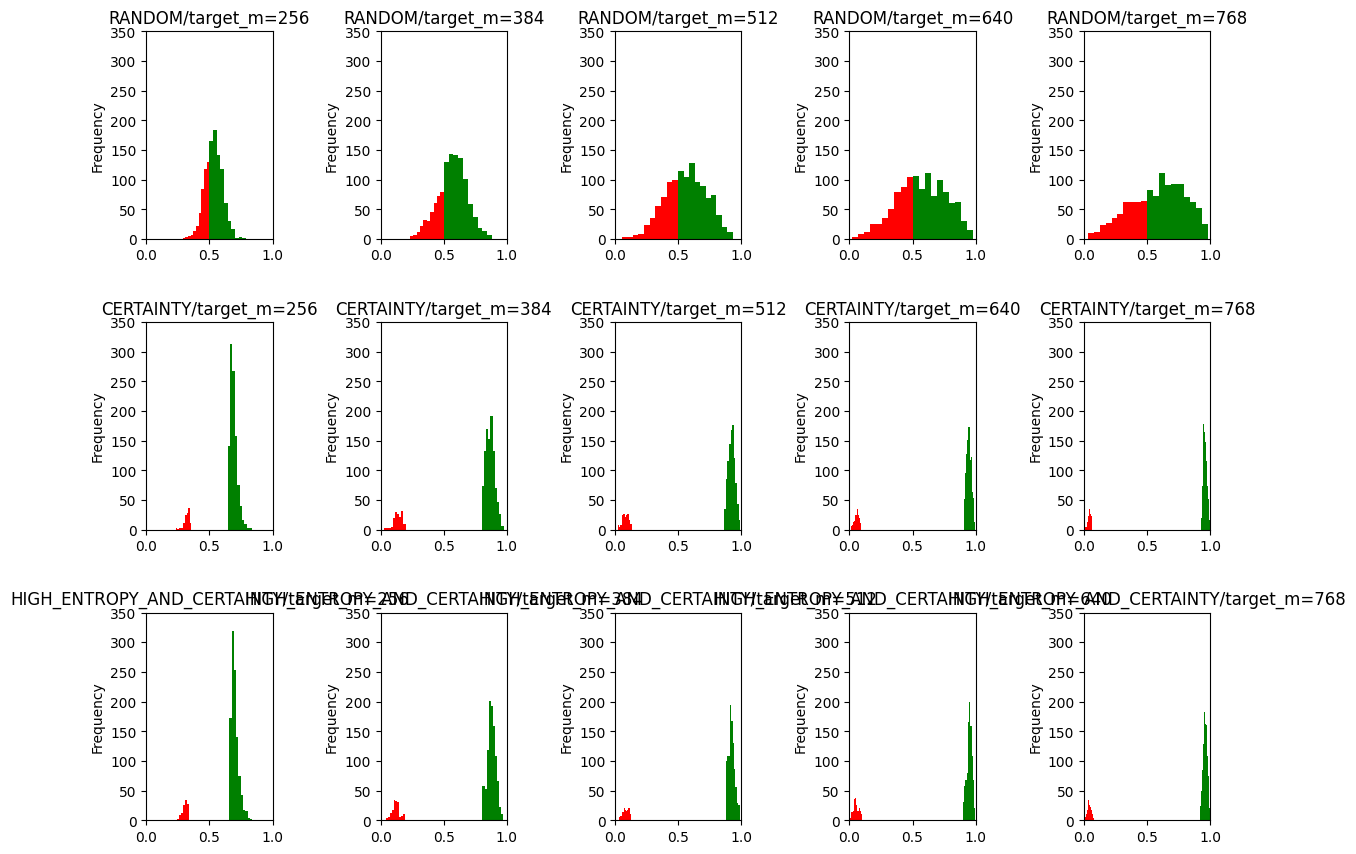

In [21]:
# This first table shows us how well calibrated the implied p(y0 > y1 | x) in the model becomes in each phase. This 
# probability is from eq 6 in the DPO paper and is derived from the r_hat values of the two prompts y0 and y1.

# We bucket it into 5 buckets 0-0.2, 0.2-0.4 etc.. showing the implied probability that y0 is prefered over y1. Then we
# plot the actual win-rate for y0 for datapoints in each bucket.  You might expect that training improves their agreement

display(
    df_imdb.groupby(
        ["target_m", "acquire_pairs_function", "p_y0_winner_bucket"]
    )["y0_winner"].agg(["count", "mean"]).unstack(level=1).fillna("")
)

ACQ_FNS = ["RANDOM", "CERTAINTY", "HIGH_ENTROPY_AND_CERTAINTY"]
plot_confidence_histos(ACQ_FNS, [256, 384, 512, 640, 768], df_imdb, 350)



count                                     \
acquire_pairs_function      CERTAINTY HIGH_ENTROPY_AND_CERTAINTY  RANDOM   
target_m p_y0_winner_bucket                                                
128      3                     1152.0                     1152.0  1152.0   
256      1                      525.0                      563.0    76.0   
         2                       18.0                              286.0   
         3                                                         446.0   
         4                       20.0                              264.0   
         5                      589.0                      589.0    80.0   
384      1                      587.0                      541.0   157.0   
         2                                                         290.0   
         3                                                         302.0   
         4                                                         268.0   
         5                      565.0                      611.0   135.0   
512      1                      586.0                      578.0   154.0   
         2                                                         242.0   
         3                                                         325.0   
         4                                                         262.0   
         5                      566.0                      574.0   169.0   

                                 mean                                       
acquire_pairs_function      CERTAINTY HIGH_ENTROPY_AND_CERTAINTY    RANDOM  
target_m p_y0_winner_bucket                                                 
128      3                   0.501736                   0.494792  0.490451  
256      1                   0.474286                   0.490231  0.460526  
         2                   0.333333                             0.444056  
         3                                                        0.457399  
         4                       0.35                             0.606061  
         5                   0.466893                   0.509338  0.550000  
384      1                   0.410562                   0.421442  0.509554  
         2                                                        0.510345  
         3                                                        0.490066  
         4                                                        0.552239  
         5                   0.589381                   0.612111  0.466667  
512      1                   0.428328                   0.451557  0.428571  
         2                                                        0.433884  
         3                                                        0.501538  
         4                                                        0.526718  
         5                   0.586572                   0.536585  0.508876

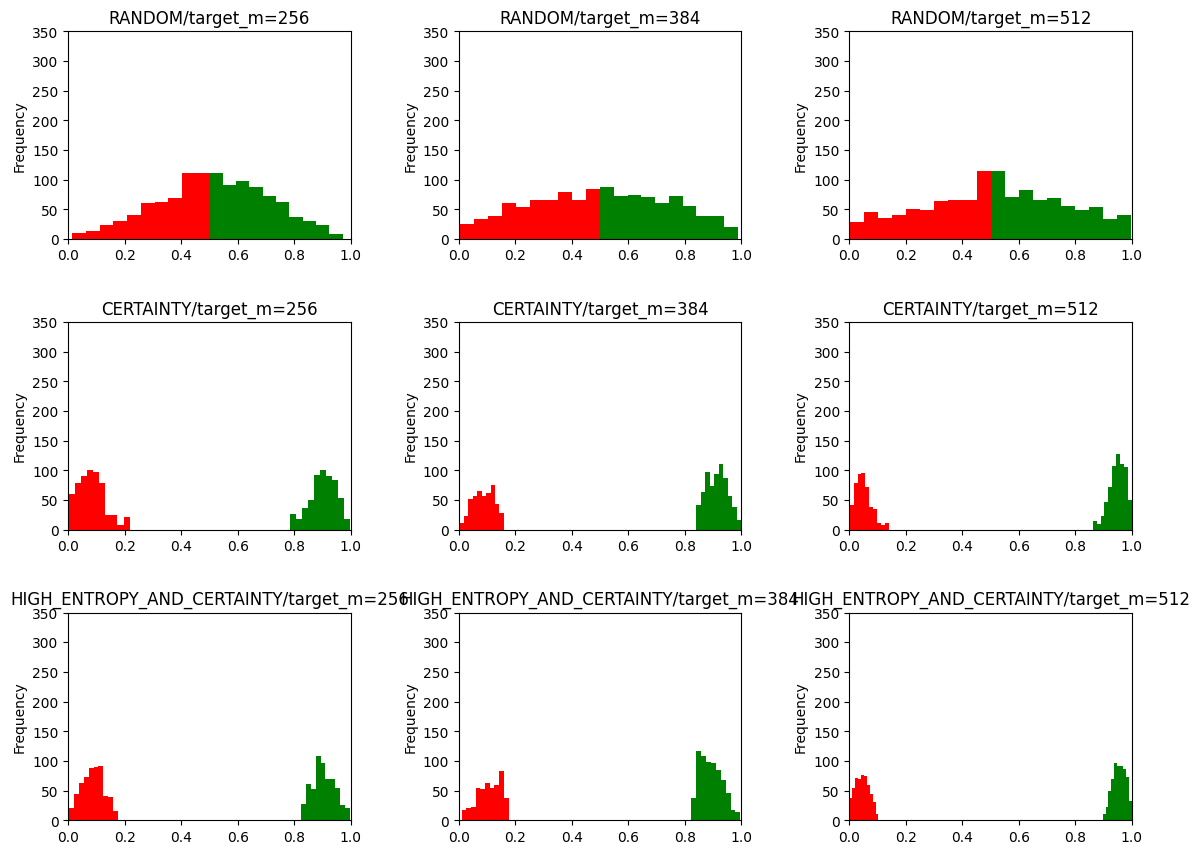

In [22]:
display(
    df_tldr.groupby(
        ["target_m", "acquire_pairs_function", "p_y0_winner_bucket"]
    )["y0_winner"].agg(["count", "mean"]).unstack(level=1).fillna("")
)

ACQ_FNS = ["RANDOM", "CERTAINTY", "HIGH_ENTROPY_AND_CERTAINTY"]
plot_confidence_histos(ACQ_FNS, [256, 384, 512], df_tldr, 350)

## Entropy analysis below - remember, these datapoints have already been filtered for high entropy and certainty!

It would have been interesting to compute entropy on an unbiased sample, however we didn't do this since it takes sooo long, even with only a few MC samples.  It was making runs take 2+ times as long.

/home/will/code/active-preference-learning/venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


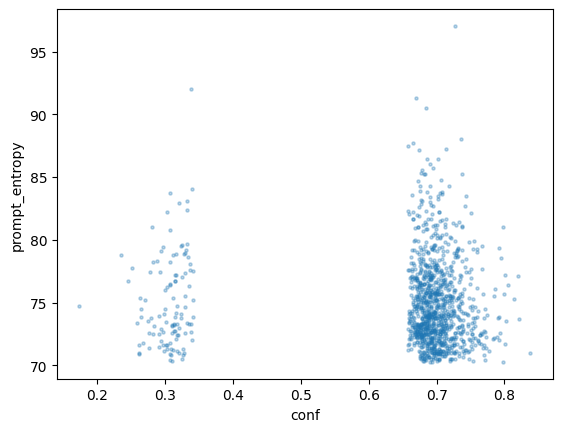

In [162]:
df_imdb[df_imdb.target_m == 256][['prompt_entropy', 'conf']].dropna().plot.scatter(y="prompt_entropy", x="conf", marker=".", alpha=0.3);

In [170]:
def analyse_entropy_vs_accuracy(df, m, quantiles):
    df = df[(df.target_m == m) & (~df.prompt_entropy.isnull())].copy()
    
    df["prompt_entropy_q"] = pd.qcut(df["prompt_entropy"], quantiles, [f"{i+1}" for i in range(quantiles)])
    
    overall_agree_rate_df = df.groupby("oracle_model_agree").prompt.count() / len(df)
    display(overall_agree_rate_df)
    
    agree_rate_df = df.groupby(["prompt_entropy_q", "oracle_model_agree"]).prompt.count() / df.groupby(["prompt_entropy_q"]).prompt.count()
    
    display(agree_rate_df)
    ax = agree_rate_df.unstack(level=1).plot.bar(stacked=True)
    ax.axhline(overall_agree_rate_df.loc[0.0], linestyle="--", color="black")



## If I squint I can see that the error rate seems higher as we go up the entropy rankings - however it might be random

Fiddling with the number of quantiles can make the effect seem to disappear - e.g. for IMDB, the 50-75 and 75-100 bucket offset each other... 

Also, changing the training stage we look at (e.g. is it data from the 128->256 phase or 256->384?), gives different suggestions

oracle_model_agree
0.0    0.09809
1.0    0.90191
Name: prompt, dtype: float64

prompt_entropy_q  oracle_model_agree
1                 0.0                   0.104167
                  1.0                   0.895833
2                 0.0                   0.097222
                  1.0                   0.902778
3                 0.0                   0.072917
                  1.0                   0.927083
4                 0.0                   0.118056
                  1.0                   0.881944
Name: prompt, dtype: float64

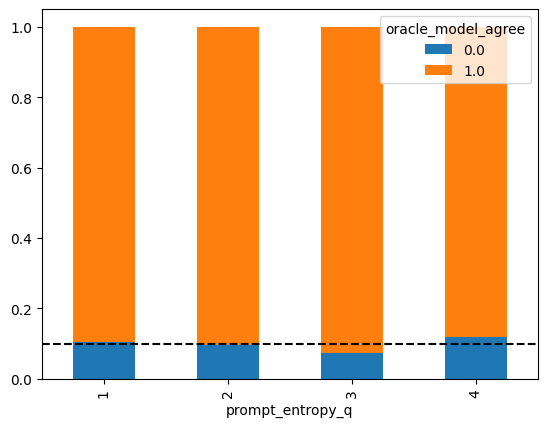

In [185]:
analyse_entropy_vs_accuracy(df_imdb, 256, 4)

oracle_model_agree
0.0    0.490451
1.0    0.509549
Name: prompt, dtype: float64

prompt_entropy_q  oracle_model_agree
1                 0.0                   0.475694
                  1.0                   0.524306
2                 0.0                   0.482639
                  1.0                   0.517361
3                 0.0                   0.500000
                  1.0                   0.500000
4                 0.0                   0.503472
                  1.0                   0.496528
Name: prompt, dtype: float64

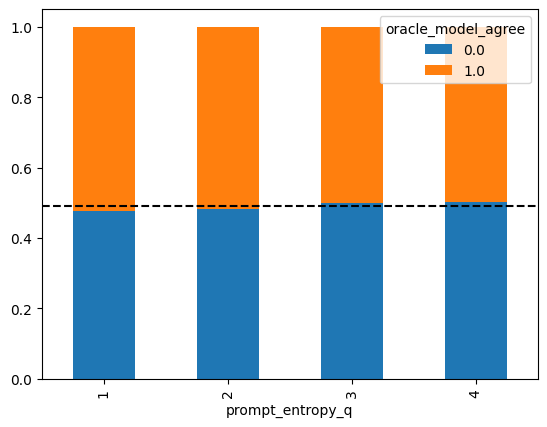

In [188]:
analyse_entropy_vs_accuracy(df_tldr, 256, 4)